In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/epic_kitchens.pickle')

In [6]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances
0,"[10.15572628962066, 10.019879244923246, 9.9284...","[0.013130092979006703, 0.013108715406449277, 0...","[9.863464335036134, 9.841094164939266, 9.82817...","[0.012930735874374388, 0.01300554677750932, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [7]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [8]:
median_len = 45

In [9]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    dist_mask = distances <= median_len
    distances = distances[dist_mask]
    sig = sig[dist_mask]
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]


In [10]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[10.15572628962066, 10.019879244923246, 9.9284...","[0.013130092979006703, 0.013108715406449277, 0...","[9.863464335036134, 9.841094164939266, 9.82817...","[0.012930735874374388, 0.01300554677750932, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.97999,0.991342,0.990502,-236.312403,-269.057246,-269.845531,pow_exp,"[1.2608438081162552e-06, 1.8903439366276627e-0...",273.0


In [11]:
from matplotlib import gridspec

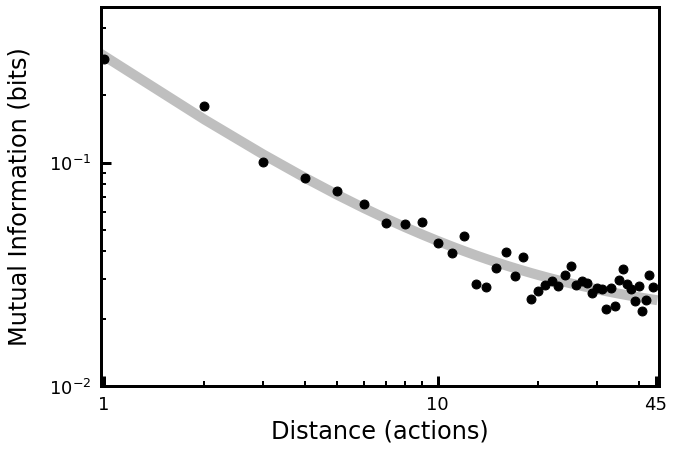

In [24]:
yoff=-.125
ncols = 4
zoom = 10
hr = [0.75, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(len(MI_DF)*zoom,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(MI_DF), nrows=4, height_ratios=hr) 

row = MI_DF.iloc[0]
axi =0

color = 'k'#LCOL_DICT[row.language]
ax0 = plt.subplot(gs[0,axi])
ax = ax0
sig = np.array(row.MI-row.shuff_MI)
distances = row.distances
sig = sig

dist_mask = distances < median_len
distances = distances[dist_mask]
sig = sig[dist_mask]

# get signal limits
sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

if axi==0: 
        ax.set_ylabel('Mutual Information (bits)', labelpad=5, fontsize=24)
        ax.yaxis.set_label_coords(yoff,0.5)

# model data
#row.concat_results.params.intercept = 0
distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)

# plot real data
ax.scatter(distances, sig, alpha = 1, s=80, color=color)   

# plot modelled data
ax.plot(distances, y_model, alpha = 0.25, lw=10, color=color)


ax.set_xlim([distances[0], distances[-1]])
sig_lims[0] = np.log(10e-6)
ax.set_ylim([1e-4, 3])
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)
ax.set_xscale( "log" , basex=10)
ax.set_yscale( "log" , basey=10)
ax.set_xticks([])
ax.set_xticks([1,10,45])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.set_ylim([1e-2, 0.5])
ax.set_xticks([1,10,45])
ax.set_xticklabels(['1','10','45'], fontsize=16)

if axi !=0:
    for ax in [ax0,ax1,ax2]:
        ax.yaxis.set_ticklabels([])

for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 

for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(18)        
       
gs.update(wspace=0.075, hspace=0.1)
ax.set_xlabel('Distance (actions)', labelpad=5, fontsize=24)

ax.set_xlim([0.98, 46])

save_fig(FIGURE_DIR/'epic_kitchens_mi')

In [13]:
MI_DF

,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[10.15572628962066, 10.019879244923246, 9.9284...","[0.013130092979006703, 0.013108715406449277, 0...","[9.863464335036134, 9.841094164939266, 9.82817...","[0.012930735874374388, 0.01300554677750932, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.97999,0.991342,0.990502,-236.312403,-269.057246,-269.845531,pow_exp,"[1.2608438081162552e-06, 1.8903439366276627e-0...",273.0


In [14]:
labels = ['Cooking']

### Calculate R2

In [15]:
R2 = MI_DF[['R2_exp', 'R2_concat', 'R2_power']]
R2.columns = ['exp', 'combined', 'power-law']
R2.index = labels
R2 = R2.T
R2

,Cooking
exp,0.979990
combined,0.991342
power-law,0.990502


### AICc

In [16]:
AICcs = MI_DF[['AICc_exp', 'AICc_concat', 'AICc_power']]
AICcs.columns = ['exp', 'combined.', 'power-law']
AICcs.index = labels
AICcs = AICcs.T
AICcs

,Cooking
exp,-236.312403
combined.,-269.057246
power-law,-269.845531


#### $\Delta$AIC

In [17]:
delta_AICcs = AICcs.T - np.repeat(np.min(AICcs.T.values, axis=1),3).reshape(len(labels),3)
delta_AICcs = delta_AICcs.T
delta_AICcs

,Cooking
exp,33.533128
combined.,0.788286
power-law,0.000000


### relative likelihood

In [18]:
relative_likelihoods = mf.relative_likelihood(delta_AICcs)
relative_likelihoods

,Cooking
exp,5.228460e-08
combined.,6.742577e-01
power-law,1.000000e+00


### relative probability of models

In [19]:
prob_models = mf.Prob_model_Given_data_and_models(relative_likelihoods)
prob_models

,Cooking
exp,3.122852e-08
combined.,4.027204e-01
power-law,5.972796e-01


#### Join tables

In [20]:
AICcs['superlabel'] = 'AICc'
relative_likelihoods['superlabel'] = 'Relative likelihood'
R2['superlabel'] = '$r^2$'
prob_models['superlabel'] = 'Relative probability'

In [21]:
results_table = pd.concat([
    AICcs,
    R2,
    relative_likelihoods,
    prob_models
]).round(3).replace(0, '<0.001').replace(1, '>0.999')
results_table[''] = results_table.index
results_table.set_index(['superlabel', ''], inplace=True)
results_table

Cooking
superlabel                             
AICc                 exp       -236.312
                     combined. -269.057
                     power-law -269.846
$r^2$                exp           0.98
                     combined     0.991
                     power-law    0.991
Relative likelihood  exp         <0.001
                     combined.    0.674
                     power-law   >0.999
Relative probability exp         <0.001
                     combined.    0.403
                     power-law    0.597

In [22]:
results_string = results_table.to_latex(bold_rows=True, escape=False)\
      .replace('>', '$>$')\
      .replace('<', '$<$')\
      .replace('superlabel', '')\
     .replace('\n\\textbf', '\n\midrule\n\\textbf')
print(results_string)

\begin{tabular}{lll}
\toprule
                     &           &  Cooking \\
\midrule
\textbf{} & {} &          \\
\midrule
\midrule
\textbf{AICc} & \textbf{exp} & -236.312 \\
                     & \textbf{combined.} & -269.057 \\
                     & \textbf{power-law} & -269.846 \\
\midrule
\textbf{$r^2$} & \textbf{exp} &     0.98 \\
                     & \textbf{combined} &    0.991 \\
                     & \textbf{power-law} &    0.991 \\
\midrule
\textbf{Relative likelihood} & \textbf{exp} &   $<$0.001 \\
                     & \textbf{combined.} &    0.674 \\
                     & \textbf{power-law} &   $>$0.999 \\
\midrule
\textbf{Relative probability} & \textbf{exp} &   $<$0.001 \\
                     & \textbf{combined.} &    0.403 \\
                     & \textbf{power-law} &    0.597 \\
\bottomrule
\end{tabular}

